# Multivariate Time Series with RNN


## NOTE: In general, it is very difficult to get good performance from an LSTM based RNN model for multivariate series. We highly recommend using SARIMAX based methods if you have a real-world situation requiring multi-variate time series data.

---
Appliance Energy Usage: A Multivariate Time Series Forecasting Example

Experimental data used to create regression models of appliances energy use in a low energy building.
Data Set Information:

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).
Original source of the dataset:

http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [7]:
df = pd.read_csv('../Data/energydata_complete.csv', index_col='date', infer_datetime_format=True)

In [8]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 

-------

# Quick EDA

In [10]:
df.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

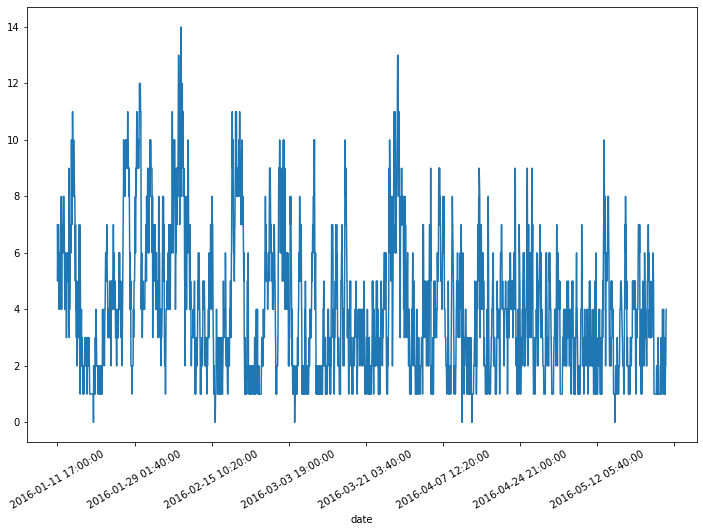

In [15]:
df['Windspeed'].plot(figsize=(12,8));
plt.xticks(rotation=30);

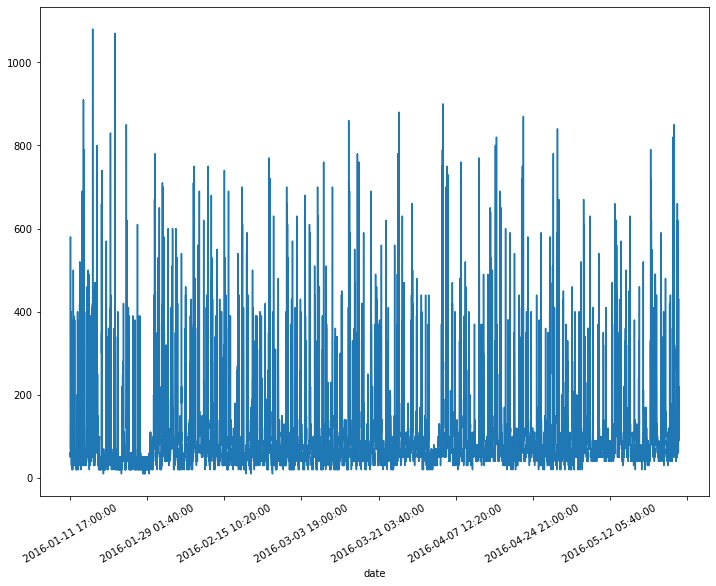

In [17]:
df['Appliances'].plot(figsize=(12,9));
plt.xticks(rotation=30);

-----

# Train Test Split

In [18]:
len(df)

19735

#### Let's imagine we want to predict just 24 hours into the future, we don't need 3 months of data for that, so let's save some training time and only select the last months data.

In [19]:
df.tail()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [21]:
df.loc['2016-05-01':]

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.200000,38.200000,18.390000,41.400000,23.200000,36.400000,19.73,37.730000,...,19.166667,38.200000,4.300000,763.700000,86.000000,2.000000,40.000000,2.200000,15.310003,15.310003
2016-05-01 00:10:00,60,0,21.150000,38.172500,18.390000,41.500000,23.133333,36.466667,19.70,37.663333,...,19.133333,38.290000,4.283333,763.716667,86.333333,2.166667,38.166667,2.216667,11.240067,11.240067
2016-05-01 00:20:00,50,0,21.133333,38.090000,18.323333,41.500000,23.200000,36.500000,19.70,37.590000,...,19.133333,38.363333,4.266667,763.733333,86.666667,2.333333,36.333333,2.233333,21.808814,21.808814
2016-05-01 00:30:00,50,0,21.100000,38.090000,18.290000,41.500000,23.200000,36.500000,19.70,37.500000,...,19.166667,38.500000,4.250000,763.750000,87.000000,2.500000,34.500000,2.250000,47.000534,47.000534
2016-05-01 00:40:00,60,0,21.100000,38.030000,18.290000,41.560000,23.200000,36.500000,19.70,37.500000,...,19.166667,38.633333,4.233333,763.766667,87.333333,2.666667,32.666667,2.266667,8.059441,8.059441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.70,45.590000,...,23.200000,46.790000,22.733333,755.200000,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.70,45.590000,...,23.200000,46.790000,22.600000,755.200000,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.70,45.730000,...,23.200000,46.790000,22.466667,755.200000,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117


In [23]:
df = df.loc['2016-05-01':]

If we look at the data such as `T1`, we can see there are so many precision for each values.

Let's also round off the data, to one decimal point precision, otherwise this may cause issues with our network (we will also normalize the data anyways, so this level of precision isn't useful to us)

In [24]:
df = df.round(2)

In [26]:
df.head(2)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.20,38.20,18.39,41.4,23.20,36.40,19.73,37.73,...,19.17,38.20,4.30,763.70,86.00,2.00,40.00,2.20,15.31,15.31
2016-05-01 00:10:00,60,0,21.15,38.17,18.39,41.5,23.13,36.47,19.70,37.66,...,19.13,38.29,4.28,763.72,86.33,2.17,38.17,2.22,11.24,11.24


## Check how batch size for sequence will be looked like.

As data are recorded per 10 mintues, we need to calculate how to set up for each batch size.

In [27]:
len(df)

3853

In [28]:
# How many rows per day? We know its every 10 min
# total minutes per day / frequency of 10 minutes => total records per day
24 * 60 / 10

144.0

In [29]:
test_days = 2 # we want to use 2 days of data as testing data

In [32]:
test_index_starting_point = test_days * 144
test_index_starting_point

288

In [33]:
# Actual Splitting
# Take note of - minus sign in indexing, we need to leave 288 rows as test data
train = df.iloc[:-test_index_starting_point]
test = df.iloc[-test_index_starting_point: ]


In [34]:
train.shape, test.shape

((3565, 28), (288, 28))

In [35]:
train.tail(2)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-25 17:50:00,90,0,24.5,37.63,24.03,34.43,25.1,36.99,24.29,37.93,...,22.0,37.36,16.42,756.12,55.17,1.83,37.83,7.38,39.36,39.36
2016-05-25 18:00:00,100,0,24.5,38.00,24.00,34.40,25.1,36.73,24.29,37.86,...,22.0,37.36,16.50,756.10,56.00,2.00,40.00,7.70,38.63,38.63


In [36]:
test.head(2)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-25 18:10:00,170,0,24.5,37.86,24.00,34.27,25.00,36.70,24.29,37.79,...,22.0,37.23,16.48,756.1,55.83,2.0,38.17,7.62,38.14,38.14
2016-05-25 18:20:00,310,0,24.5,37.30,23.86,34.33,24.94,36.67,24.29,37.79,...,22.0,37.36,16.47,756.1,55.67,2.0,36.33,7.53,31.16,31.16


---------

# Scale Data

In [37]:
from sklearn.preprocessing import MinMaxScaler

In [38]:
scaler = MinMaxScaler()

In [39]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

------

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [44]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

**NOTE: edit the length so that it makes sense for your time series!**

In [45]:
length = 144 # for one day full daily cycle
batch_size = 1

In [47]:
generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train,
                                                   length=length, batch_size=1)

In [50]:
# What does the first batch look like?
X,y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'\nPredict this y: \n {y}')

Given the Array: 
[0.03896104 0.         0.13798978 ... 0.14319527 0.75185111 0.75185111]

Predict this y: 
 [[0.03896104 0.         0.30834753 0.29439421 0.16038492 0.49182278
  0.0140056  0.36627907 0.24142857 0.24364791 0.12650602 0.36276002
  0.12       0.28205572 0.06169297 0.15759185 0.34582624 0.39585974
  0.09259259 0.39649608 0.18852459 0.96052632 0.59210526 0.1
  0.58333333 0.13609467 0.4576746  0.4576746 ]]


-------

# Model Building

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Reflect the mulitvariate features for number of features 

In [51]:
scaled_train.shape

(3565, 28)

In [53]:
n_features = scaled_train.shape[1]
n_features

28

In [56]:
model = Sequential()

# Simple RNN Layer
model.add(LSTM(100, input_shape=(length, n_features)))

# Final Prediction (one neuron per feature)
model.add(Dense(n_features))
          
model.compile(optimizer='adam', loss='mse')

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               51600     
_________________________________________________________________
dense (Dense)                (None, 28)                2828      
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________


-----

# EarlyStopping and Validation Generator

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

In [60]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=2)

In [61]:
validation_generator = TimeseriesGenerator(data=scaled_test, targets=scaled_test,
                                                                      length=length, batch_size=batch_size)

-----

# Model Training

#### As we are now dealing with Multivariate Timeseries and there are a lot of features, we need to consider lower number of epochs to train on.

In [62]:
model.fit(generator, 
             epochs=2,
             validation_data = validation_generator,
             callbacks=[early_stopping],
             verbose=1)

Epoch 1/2
3421/3421 [==============================] - 152s 44ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 2/2
3421/3421 [==============================] - 157s 46ms/step - loss: 0.0079 - val_loss: 0.0092


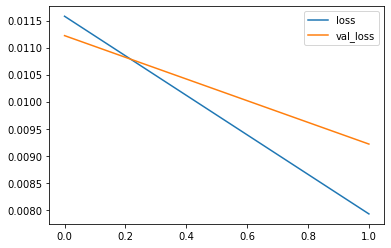

In [63]:
losses = pd.DataFrame(model.history.history)
losses.plot();

----------

# Evaluate on Test Data

In [64]:
test_predictions = []

first_evaluation_batch = scaled_train[-length: ]
current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_prediction = model.predict(current_batch)[0]
    
    test_predictions.append(current_prediction)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)

# Inverse Transformations and Compare

In [65]:
true_predictions = scaler.inverse_transform(test_predictions)

In [66]:
true_predictions_df = pd.DataFrame(data=true_predictions, columns=test.columns)

In [67]:
true_predictions_df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,105.513212,3.320100,24.434543,38.031104,24.277211,35.276308,25.079605,37.023892,23.952222,37.022506,...,22.072506,38.023030,16.795420,756.066685,57.700998,2.230769,36.865144,7.569594,23.760460,25.647860
1,111.244663,4.528213,24.435531,38.172667,24.231856,35.853338,25.067250,37.070755,23.903068,37.137094,...,22.105541,38.337015,17.017254,756.027694,58.103538,2.426337,35.476775,7.815580,24.569094,26.158112
2,113.741887,5.332637,24.428873,38.248952,24.185040,36.153335,25.045987,37.103238,23.873696,37.235559,...,22.141369,38.639513,17.058367,755.921104,58.251036,2.572959,33.787146,7.942222,25.304431,26.955495
3,115.238806,5.907305,24.416213,38.305367,24.134080,36.391396,25.012960,37.126821,23.844445,37.307714,...,22.167315,38.912531,17.087300,755.845158,58.390923,2.697640,31.992881,8.011880,25.983915,27.645032
4,115.925140,6.326018,24.399831,38.343268,24.077480,36.598237,24.970189,37.140067,23.810039,37.360640,...,22.183287,39.152409,17.109250,755.805311,58.549426,2.817962,30.234244,8.048265,26.617117,28.266177


# Evaluation

+ If we want to evaluate our model predictions, we can compare RMSE on features that we consider important.
+ Or if we want the RMSE as a whole for every features, we can cosider weight average
+ However we need to take note that every features scale are different, we might want to use scaled version values to compare againt each other.

# Save Model

In [68]:
from tensorflow.keras.models import load_model

In [69]:
model.save('../Models/multivariate.h5')